In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

from ebov_data import *

if locations:
    pass
else:
    status()
    setFocusCountries(['SLE','LBR','GIN'])
    setColourMaps()
    loadData()

typeface='Helvetica Neue' ## set default matplotlib font and font size
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def kde_scipy( vals1, vals2, (a,b), (c,d), N ):
    """ Performs 2D kernel density estimation.
        vals1, vals2 are the values of two variables (columns)
        (a,b) interval for vals1 over which to estimate first axis KDE
        (c,d) -"-          vals2 over which to estimate second axis KDE
        N is number of equally spaced points over which to estimate KDE.
     """
    x=np.linspace(a,b,N)
    y=np.linspace(c,d,N)
    X,Y=np.meshgrid(x,y)
    positions = np.vstack([Y.ravel(), X.ravel()])

    values = np.vstack([vals1, vals2])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return [x, y, Z]

xml_path=path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run2/Makona_1610_cds_ig.joint_GLM.xml' ## path to XML

lpaths=[path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run%d/Makona_1610_cds_ig.GLM.log'%(run) for run in range(1,3)]
hpaths=[path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run%d/Makona_1610_cds_ig.GLM.history.log'%(run) for run in range(1,3)]

tip_dates=[]
for line in open(xml_path,'r'): 
    cerberus=re.search('<taxon id="[A-Za-z\_\|0-9?]+\|([0-9\-]+)',line) ## collect all sequence collection dates
    if cerberus is not None:
        tip_dates.append(cerberus.group(1))

mostRecent=max(map(decimalDate,tip_dates)) ## find most recent one

matrix_index={} ## predictor matrix indexing
origin_indices={x:[] for x in locations}
destination_indices={x:[] for x in locations}

lg=len(locations)
for i in range(len(locations)):
    for j in range(i+1,len(locations)):
        
        locA=locations[i]
        countryA=location_to_country[locA]
        
        locB=locations[j]
        countryB=location_to_country[locB]
        
        f1=int((lg*(lg-1)/2) - (lg-i)*((lg-i)-1)/2 + j - i - 1) ## indexing of a flattened GLM matrix
        f2=int((lg*(lg-1)) - (lg-i)*((lg-i)-1)/2 + j - i - 1)

        matrix_index[f1]=(locations[i],locations[j])
        matrix_index[f2]=(locations[j],locations[i])
        
        origin_indices[locA].append(f1)
        origin_indices[locB].append(f2)
        
        destination_indices[locB].append(f1)
        destination_indices[locA].append(f2)

predictor_description={} ## this will contain the predictor description taken from the comment before the GLM matrix

read_matrix=False ## flag to read the matrices

predictors=[] ## this will contain the predictor name
description=''

read_loc=False ## flag to read locations

xml_districts=[] ## this will contain location names

counter=1
store=''
print 'predictors found:'
for line in open(xml_path,'r'): ## iterate through XML by line
    descriptionRegex='<!-- predictor [0-9]+\: ([A-Za-z\_\.\(\)\-0-9\, +>]+) -->'
    matrixRegex='<parameter id="([A-Za-z0-9\_\.]+)" value="'
    
    matrixID=re.search(matrixRegex,line) ## search for matrix
    valid_description=re.search(descriptionRegex,store) ## look at whether previous line was a valid description of a predictor
    if matrixID is not None and valid_description is not None:
        predictor=matrixID.group(1)
        predictors.append(predictor)
        predictor_description[predictor]=description
        print ' & %s & %s \\\\ \\hline'%(predictor,description)
        
        counter+=1

    descriptionID=re.search(descriptionRegex,line) ## search for matrix description
    if descriptionID is not None:
        description=descriptionID.group(1)
    
    if 'location.dataType' in line: ## identify when to start reading location names
        read_loc=True

    cerberus=re.search('<state code="([A-Za-z]+)"/>',line) ## log location
    if read_loc==True and cerberus is not None:
        xml_districts.append(cerberus.group(1))
    
    store=line ## remember line for next iteration
    
burnin=10000000 ## define burnin for GLM log file, identify the name of the trait
trait='location'

required_coeffs=['%s.glmCoefficients%d'%(trait,x+1) for x in range(len(predictors))] ## identify what the indicator and coefficient names in the log file will be
required_indicators=['%s.coefIndicator%d'%(trait,x+1) for x in range(len(predictors))]

GLM_coeffs={x:[] for x in predictors} ## create a dict of lists that will contain posterior samples
GLM_indicators={x:[] for x in predictors}

for log_path in lpaths:
    for line in open(log_path,'r'): ## iterate through the log file
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            indices_coeffs=[i for i,x in enumerate(header) if x in required_coeffs]
            indices_indicators=[i for i,x in enumerate(header) if x in required_indicators]
        elif '#' in line:
            pass

        elif int(l[0])>=burnin: ## start logging posterior states past the burnin
            for i,j,x in zip(indices_coeffs,indices_indicators,predictors): ## iterate through indices where indicators and coefficients of known predictors will be
                GLM_indicators[x].append(float(l[j]))
                GLM_coeffs[x].append(float(l[i]))

frame='<iframe style="border: 0; width: 400px; height: 308px;" src="https://bandcamp.com/EmbeddedPlayer/album=2789340638/size=large/bgcol=333333/linkcol=e99708/artwork=small/track=1338962038/transparent=true/" seamless><a href="http://vilkduja.bandcamp.com/album/insomnia-ep">Insomnia EP by Vilkduja</a></iframe>'

priorProbability=1-math.pow(0.5,(1/float(len(predictors)))) ##### calculates prior odds
priorOdds=float(priorProbability/float(1-priorProbability))

BFs={} ## BFs for individual indicators being on
print '\npredictor analysis:'
print '%3s%30s%5s%13s%4s%9s'%('idx','predictor','N','ln coeff','pp','BF')

GLM_conditional_coeffs={}

for i,x in enumerate(predictors):
    L=len(GLM_indicators[x])
    if L==0:
        GLM_coeffs.pop(x,None)
        GLM_indicators.pop(x,None)
    else:
        MCMClen=L
        support=np.mean(GLM_indicators[x])
        conditioned_coeff=[a for a,b in zip(GLM_coeffs[x],GLM_indicators[x]) if b==1.0]
        GLM_conditional_coeffs[x]=conditioned_coeff
        posteriorOdds=(((support-(1/float(MCMClen)))/float((1-(support-(1/float(MCMClen)))))))
        BFs[x]=posteriorOdds/float(priorOdds)
        note=' '
        if BFs[x]>3.0:
            note='*'
        print '%3s%s%30s%6d%9.2f%8.2f%11.2f'%(i+1,note,x,len(GLM_coeffs[x]),np.mean(conditioned_coeff),support,BFs[x])

#########################################################################################
#### IMPORT PREDICTOR MATRICES    #######################################################
#########################################################################################

within_country=[]
between_countries=[]

distance_matrix={x:{y:0 for y in popCentres.keys()} for x in popCentres.keys()} ## find distance in kilometres between every location population centroid
for x in popCentres.keys():
    pointA=popCentres[x]
    for y in popCentres.keys():
        pointB=popCentres[y]
        distance_matrix[x][y]=metricDistance(pointA,pointB)

all_times=[]
all_distances=[]

within={x:[] for x in required_countries}
between={x:{y:[] for y in required_countries if x!=y} for x in required_countries}
country_jump_to={x:{} for x in required_countries}
country_jump_from={x:{} for x in required_countries}

jump_matrix={x:{y:0 for y in popCentres.keys() if x!=y} for x in popCentres.keys()}
posteriors=[]
country_jump_matrix={x:{y:{} for y in required_countries} for x in required_countries}
location_jump_matrix={x:{y:{} for y in locations} for x in locations}


jumps_to={y:[] for y in popCentres.keys()}
jumps_from={y:[] for y in popCentres.keys()}

MCMClen=0

# burnin=10000000
burnin=20000000
for history_path in hpaths:
    for line in open(history_path,'r'): ## iterate through the history file
        l=line.strip('\n').split('\t')
        if '#' in line or 'state' in line:
            pass
        elif float(l[0])>=burnin:
            MCMClen+=1
            try:
                N_transitions=int(float(l[-1]))
            except:
                N_transitions=int(float(line.split(' ')[-1].strip('\n')))

            cerberus=re.findall('{[0-9]+,[0-9\.]+,[A-Za-z]+,[A-Za-z]+}',l[2]) ## fetch all transitions

            local_matrix={x:{y:0 for y in popCentres.keys() if x!=y} for x in popCentres.keys()}

            withins=0
            betweens=0

            for trans in cerberus: ## iterate over each event
                log,height,origin,destination=trans[1:-1].split(',')

                height=float(height)

                countryA=location_to_country[origin] ## get country for start and end locations
                countryB=location_to_country[destination]

                pointA=popCentres[origin]
                pointB=popCentres[destination]

                distance=distance_matrix[origin][destination]
                absoluteTime=mostRecent-height

                all_times.append(absoluteTime) ## remember time of transition

                all_distances.append(distance) ## remember distance

                jump_matrix[origin][destination]+=1 ## add to number of known transitions between locations

                jumps_to[destination].append(absoluteTime) ## add time to known jumps to and from the locations
                jumps_from[origin].append(absoluteTime)

                if countryA!=countryB: ## if jump is between countries - remember time and distance in the between category
                    betweens+=1
                    between[countryA][countryB].append((absoluteTime,distance))

                    if country_jump_from[countryA].has_key(MCMClen):
                        country_jump_from[countryA][MCMClen]+=1
                    else:
                        country_jump_from[countryA][MCMClen]=1

                    if country_jump_to[countryB].has_key(MCMClen):
                        country_jump_to[countryB][MCMClen]+=1
                    else:
                        country_jump_to[countryB][MCMClen]=1  

                elif countryA==countryB: ## otherwise - in within category
                    withins+=1
                    within[countryA].append((absoluteTime,distance))

                if location_jump_matrix[origin][destination].has_key(MCMClen):
                    location_jump_matrix[origin][destination][MCMClen].append(absoluteTime)
                else:
                    location_jump_matrix[origin][destination][MCMClen]=[absoluteTime]

                if country_jump_matrix[countryA][countryB].has_key(MCMClen):
                    country_jump_matrix[countryA][countryB][MCMClen].append(absoluteTime)
                else:
                    country_jump_matrix[countryA][countryB][MCMClen]=[absoluteTime]

            if len(cerberus)!=N_transitions: ## make sure that the number of found jumps matches what BEAST reported
                print 'Number of transitions found (%d) does not match reported number (%d) at state %s'%(len(cerberus),N_transitions,l[0])

            posteriors.append(withins/float(betweens)) ## add ratio of within to between jumps to a separate list

location_jump_matrix['WesternArea']={loc:{} for loc in locations}
for destination in locations:
    for mcmc in range(MCMClen):
        urban=[]
        rural=[]
        if location_jump_matrix['WesternRural'][destination].has_key(mcmc):
            rural=location_jump_matrix['WesternRural'][destination][mcmc]
        if location_jump_matrix['WesternUrban'][destination].has_key(mcmc):
            urban=location_jump_matrix['WesternUrban'][destination][mcmc]
            
        location_jump_matrix['WesternArea'][destination][mcmc]=urban+rural
        
        urban=[]
        rural=[]
        if location_jump_matrix[destination]['WesternRural'].has_key(mcmc):
            rural=location_jump_matrix[destination]['WesternRural'][mcmc]
        if location_jump_matrix[destination]['WesternUrban'].has_key(mcmc):
            urban=location_jump_matrix[destination]['WesternUrban'][mcmc]
        location_jump_matrix[destination]['WesternArea']={}
        location_jump_matrix[destination]['WesternArea'][mcmc]=urban+rural
        
print 'Done! (%d MCMC states loaded)'%(MCMClen)
HTML(frame)

Operating system:       Darwin (15.6.0)
Python version:         2.7.12
Numpy version:          1.11.3
Pandas version:         0.18.1
matplotlib version:      2.0.0
scipy version:          0.18.1

This notebook was last run on:
Monday	2017-Feb-27	15:29	PDT
predictors found:
 & greatCircleDistances & great-circle Distances standardized, ln-transformed, standardized \\ \hline
 & within_country & within country effect \\ \hline
 & international_border_shared & location pairs that are in different countries and share a border \\ \hline
 & national_border_shared & location pairs that are in the same country and share a border \\ \hline
 & betweenLBR_GIN_Assymetry & between Liberia-Guinea assymetry \\ \hline
 & betweenLBR_SLE_Assymetry & between Liberia-Sierra Leone assymetry \\ \hline
 & betweenGIN_SLE_Assymetry & between Guinea-Sierra Leone assymetry \\ \hline
 & originTT100k & estimated mean travel time in minutes to reach the nearest major settlement of at least 100,000 people at origin, 

3 Bayes factor cut-off = 0.0778
15 Bayes factor cut-off = 0.2966
50 Bayes factor cut-off = 0.5843
['originTmpss', 'destinationPop_Size', 'greatCircleDistances', 'originPop_Size', 'within_country', 'international_border_shared']
index of temperature seasonality at origin, ln-transformed, standardized
                             originTmpss	-0.57 [-1.08, -0.15]	           3.49	0.0895
destination population size, ln-transformed, standardized
                     destinationPop_Size	0.77 [0.45, 1.10]	            >50	0.9998
great-circle Distances standardized, ln-transformed, standardized
                    greatCircleDistances	-0.77 [-0.92, -0.63]	            >50	1.0000
origin population size, ln-transformed, standardized
                          originPop_Size	1.36 [0.83, 1.87]	            >50	1.0000
within country effect
                          within_country	3.12 [2.43, 3.86]	            >50	1.0000
location pairs that are in different countries and share a border
             inter

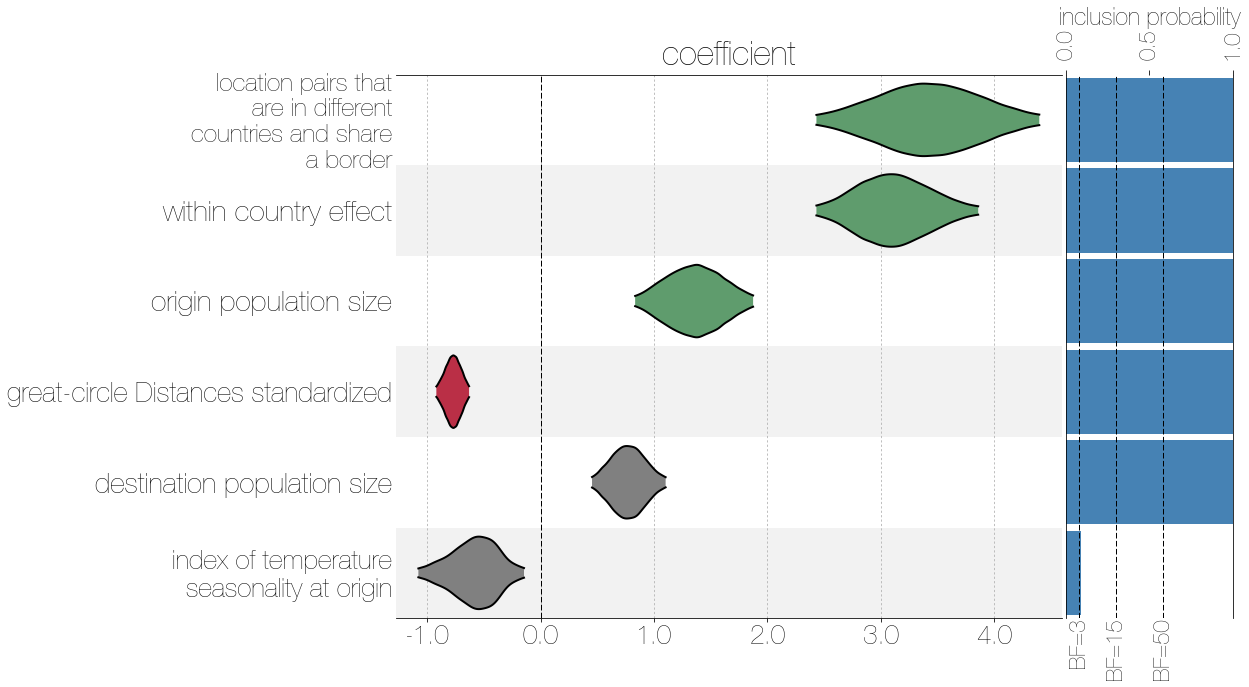

In [2]:
fig = plt.figure(figsize=(15, 10)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1],wspace=0.01) ## setup figure with two columns

ax = plt.subplot(gs[0]) ## violins go into this subplot
ax2 = plt.subplot(gs[1]) ## horizontal inclusion probability bars go into this subplot

leftedge=0 ## these will provide x axis limits later on
rightedge=0

ax2.set_xlabel('inclusion probability',size=24) ## set x labels for both figures
ax.set_xlabel('coefficient',size=34)

ax2.xaxis.set_label_position('top')
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad=10

plotBFs=[3,15,50] ## plot inclusion probabilities for BF=3, 15 and 50
cutoffs={}
for bf in plotBFs:
    posteriorOdds=priorOdds*bf
    cutoffs[bf]=posteriorOdds/(1+posteriorOdds)
    print '%d Bayes factor cut-off = %.4f'%(bf,cutoffs[bf])
    ax2.axvline(cutoffs[bf],color='k',lw=1,ls='--')
    ax2.text(cutoffs[bf],-0.5,'BF=%d'%(bf),size=22,ha='center',va='top',rotation=90)

predictors=sorted(GLM_coeffs.keys(),key=lambda x:(np.mean(GLM_indicators[x]),np.mean(GLM_conditional_coeffs[x]))) ## sort predictor names by support, then by coefficient

significant=[x for x in GLM_conditional_coeffs.keys() if np.mean(GLM_indicators[x])>=priorOdds*min(plotBFs)]
significant=sorted(significant,key=lambda x:(np.mean(GLM_indicators[x]),np.mean(GLM_coeffs[x])))
print significant

for i,x in enumerate(significant): ## for each predictor plot violins     
    support=np.mean(GLM_indicators[x])
    
    if support>=min(cutoffs.values()): ## if BF >minimum then plot coefficients conditional on it being turned on
        posterior_samples=[val for val,ind in zip(GLM_coeffs[x],GLM_indicators[x]) if ind==1.0] ## conditioned
#         posterior_samples=[val*ind for val,ind in zip(GLM_coeffs[x],GLM_indicators[x])] ## product of coefficient and indicator ("actual rate")
    else:
        posterior_samples=GLM_coeffs[x] ## otherwise plot all samples
        
    w=0.4 ## width of violins
    
    k1 = gaussian_kde(posterior_samples) #calculates the kernel density
    
    mu=np.mean(posterior_samples)
    m1,M1=hpd(posterior_samples,0.95) ## get HPDs
    
    if x in significant:
        #print predictor_description[x]
        posteriorOdds=(((support-(1/float(MCMClen)))/float((1-(support-(1/float(MCMClen)))))))
        BF=posteriorOdds/float(priorOdds)
        if BF>50.0:
            BF='%15s'%('>50')
        else:
            BF='%15.2f'%(BF)
        print '%s\n%40s\t%.2f [%.2f, %.2f]\t%s\t%.4f'%(predictor_description[x],x,mu,m1,M1,BF,support)
    
    if m1<=leftedge: ## define new x axis minimum if new HPD is lower than current one
        leftedge=m1
    if M1>=rightedge:
        rightedge=M1

    x1 = np.linspace(m1,M1,100)  ## create a range of 100 values between lower and upper HPDs
    v1 = k1.evaluate(x1)  ## evaluate KDEs at each of the 100 values
    v1 = v1/v1.max()*w ## rescale to fit inside defined violin width

    supportFrac=min([1.0,support/float(min(cutoffs.values()))]) ## ratio of inclusion probability and smallest BF required, limited to 1.0
    
    if M1<0.0 and m1<0.0: ## define fill colours for violins depending on whether they're inside or outside HPDs
        fcolour='#BA2F46'
    elif M1>0.0 and m1>0.0:
        fcolour=desaturate(mpl.cm.Greens(0.6),0.6)
    if support<1.0:
        fcolour='grey'
     
    ax.fill_between(x1,[i+q for q in v1],[i-q for q in v1],facecolor=desaturate(fcolour,supportFrac),edgecolor='none',alpha=supportFrac,zorder=100) ## plot violin, colour is desaturated depending on inclusion probability
    
    fcolour='k'
    ax.plot(x1,[i+w for w in v1],color=desaturate(fcolour,supportFrac),lw=2,alpha=1,zorder=100) ## plot nice edges for each violin (upper and lower)
    ax.plot(x1,[i-w for w in v1],color=desaturate(fcolour,supportFrac),lw=2,alpha=1,zorder=100)
    
    if i%2==0: ## even numbered predictor - add a grey shaded area in the background
        ax.axhspan(i-0.5,i+0.5,facecolor='k',edgecolor='none',alpha=0.05,zorder=0)
    
    ax2.barh(i,support,height=0.93,lw=2,align='center',edgecolor='none',
             facecolor=desaturate('steelblue',supportFrac)) ## plot inclusion probability

ylabels=[]
for pred in significant: ## define descriptions for each predictor to be used as y axis labels
    break_at=3
    desc=predictor_description[pred]
    
    if len(desc.split(', +1'))>1: ## rectify description of predictor matrices
        description=''.join(desc.split(', +1')[:-1])
    elif len(desc.split('pseudo'))>1:
        description=''.join(desc.split(', pseudo')[:-1])
    elif len(desc.split('ln-'))>1:
        description=''.join(desc.split(', ln')[:-1])
    elif len(desc.split(',  0'))>1:
        description=''.join(desc.split(',  0')[:-1])
    else:
        description=desc
    
    break_description='\n'.join([' '.join([y for y in description.split(' ')[x:x+break_at]]) for x in range(0,len(description.split(' ')),break_at)]) ## breaks up the description into new lines to fit nicely
    
    ylabels.append(r'%s'%(break_description))
    
ax.axvline(0,ls='--',lw=1,color='k') ## add a horizontal line to main plot at coeff=0
ax.grid(axis='x',ls=':')

ax.spines['right'].set_color('none') ## make plot pretty
ax.spines['left'].set_color('none')

ax.yaxis.tick_left()

ax.set_yticks(np.arange(0,len(predictors)))
ax.set_yticklabels(ylabels,size=20)

for tick in ax.get_yticklabels():
    tick.set_size(40-np.log10(len(list(tick.get_text())))*8)

ax2.xaxis.tick_top()
ax2.set_xticks(np.linspace(0,1,3))
ax2.set_xticklabels(np.linspace(0,1,3),rotation=90)
ax2.tick_params(axis='y',size=0)
ax2.set_yticklabels([])
ax2.tick_params(axis='x',size=5,labelsize=22,direction='out',pad=10)

ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.tick_params(axis='x',labelsize=26,direction='out')
ax.tick_params(axis='y',size=0)

ax.set_ylim(-0.5,len(significant)-0.5)
ax2.set_ylim(-0.5,len(significant)-0.5)
ax.set_xlim(leftedge-0.2,rightedge+0.2)
ax2.set_xlim(0,1)

# plt.savefig(local_output+'coeff.png',dpi=100,bbox_inches='tight')
# plt.savefig(local_output+'coeff.pdf',dpi=100,bbox_inches='tight')
plt.show()

# Analysis of jump counts

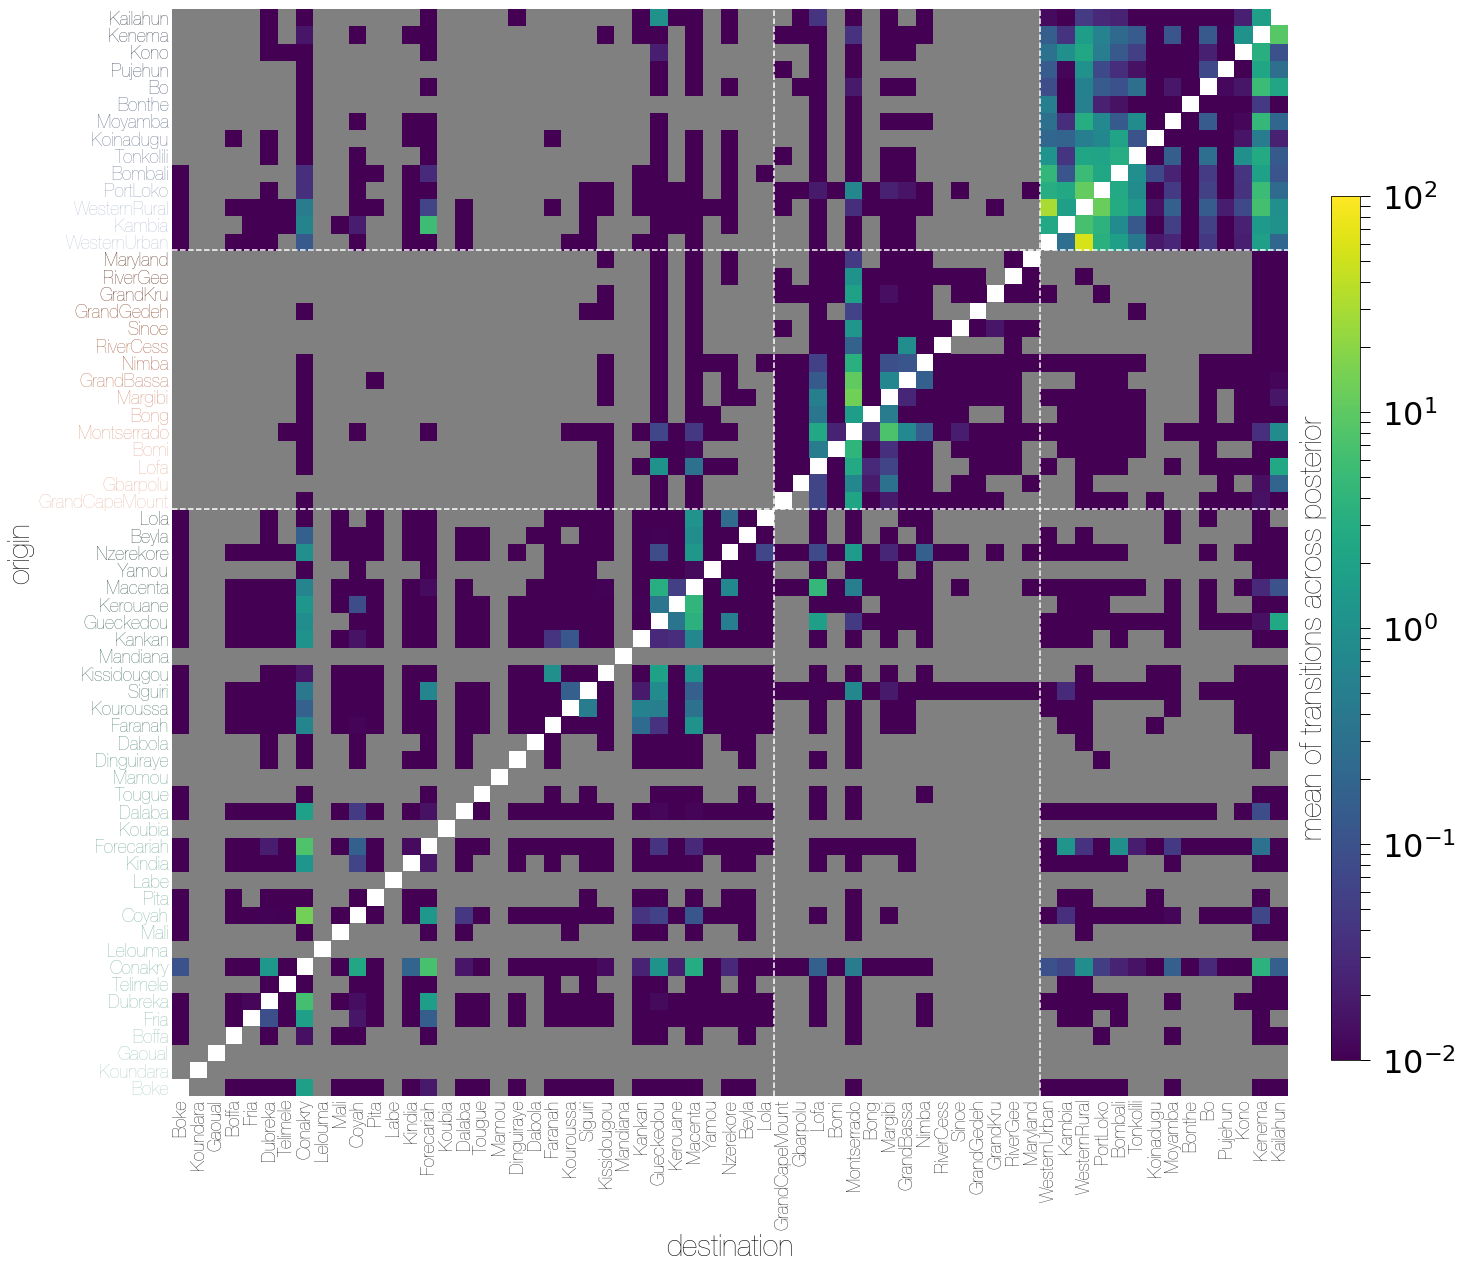

In [3]:
loc_subset=[loc for loc in locations if location_to_country[loc] in required_countries]

empty=np.zeros((len(loc_subset),len(loc_subset))) ## empty matrix
empty.fill(np.nan)

sorted_locations=sorted(loc_subset,key=lambda x:(location_to_country[x],normalized_coords[x])) ## sort locations by country, normalized coordinate within country
analysis=pd.DataFrame(empty,index=sorted_locations,columns=sorted_locations)

for i in loc_subset:
    for j in loc_subset:
        if i!=j:
            analysis[i][j]=jump_matrix[i][j]/float(MCMClen) ## calculate posterior number of jumps

fig,ax = plt.subplots(figsize=(20,20),facecolor='w') ## start figure

masked_array = np.ma.array(np.array(analysis),mask=np.isnan(analysis)) # mask NaNs

cmap=mpl.cm.viridis ## colour map
cmap.set_bad('grey',1.)

norm=mpl.colors.LogNorm(vmin=10.0**-2,vmax=10.0**2) ## normalize within range
heatmap = ax.pcolor(masked_array,edgecolors='none', linewidths=0,cmap=cmap,alpha=1,norm=norm) ## heatmap

ax.set_yticks(np.arange(0.5,len(sorted_locations)+0.5))
ax.set_yticklabels(sorted_locations)

ax.set_xticks(np.arange(0.5,len(sorted_locations)+0.5))
ax.set_xticklabels(sorted_locations,rotation=90)

ax.set_xlabel('destination',size=30)
ax.set_ylabel('origin',size=30)
ax.tick_params(size=0,labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

countries_of_labels=[location_to_country[x] for x in sorted_locations]
for c in range(len(countries_of_labels)-1):
    if countries_of_labels[c]!=countries_of_labels[c+1]:
        ax.axhline(c+1,ls='--',color='w') ## delimit countries on x and y axes
        ax.axvline(c+1,ls='--',color='w')

axcb = fig.add_axes([0.93, 0.15, 0.02, 0.6], frame_on=False) ## colour bar
cb = mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=norm,orientation='vertical',alpha=1.0,drawedges=False)

axcb.yaxis.set_label_position("left")
axcb.set_ylabel('mean of transitions across posterior',size=30)
axcb.tick_params(axis='y',which='both',direction='out',size=12,width=1,pad=10)
plt.setp(axcb.get_yticklabels(),size=32,name=typeface)

for tick in axcb.yaxis.get_ticklines():
    tick.set_markersize(10)

for tick in ax.yaxis.get_ticklabels():
    label=str(tick.get_text())
    tick.set_color(desaturate(colours[location_to_country[label]](normalized_coords[label]),0.8))

# plt.savefig(local_output+'EBOV_transition_matrix.png',dpi=200,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_transition_matrix.pdf',dpi=200,bbox_inches='tight')
plt.show()

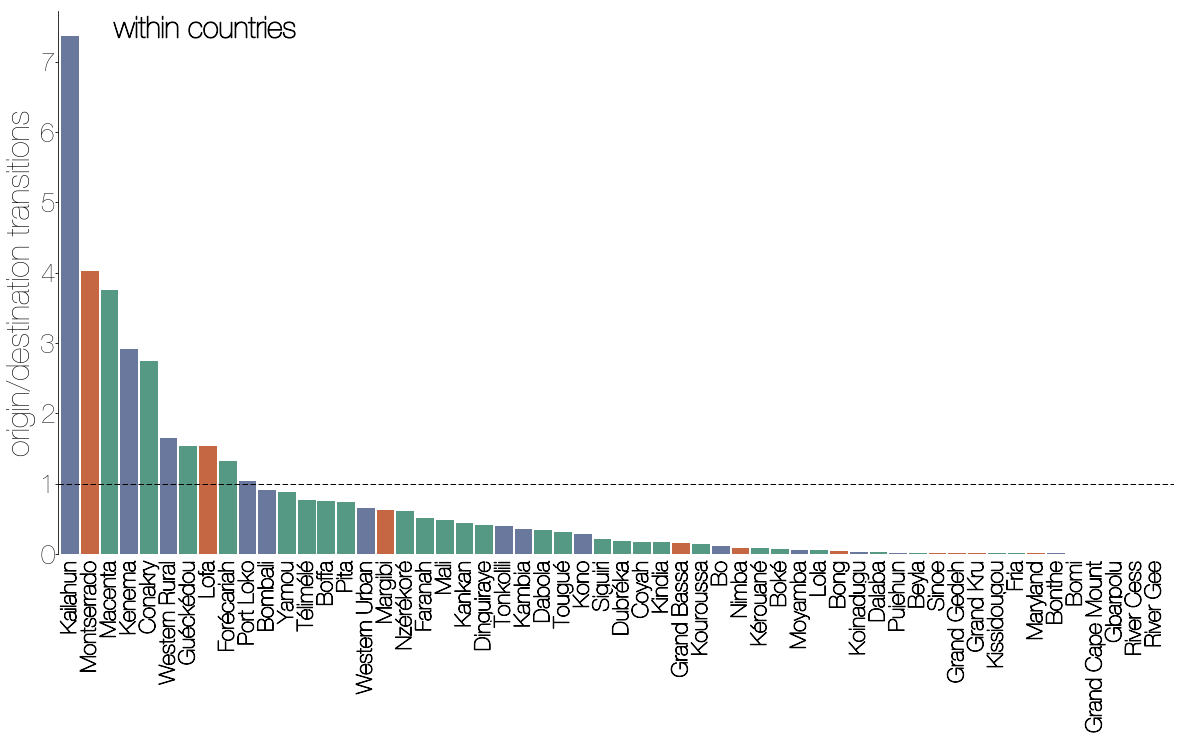

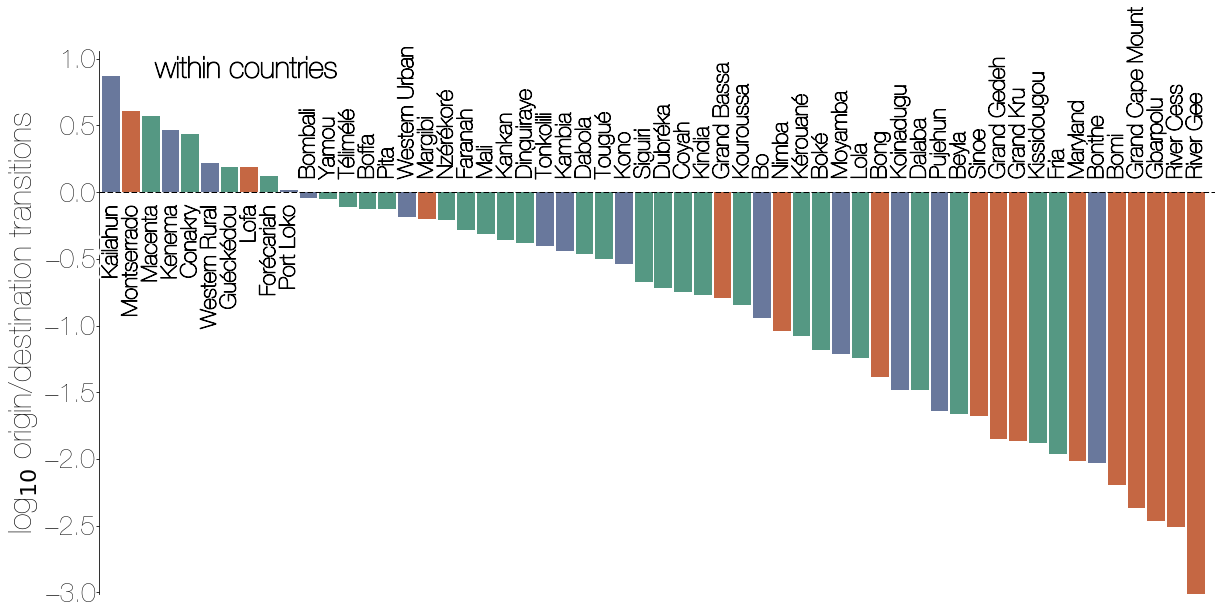

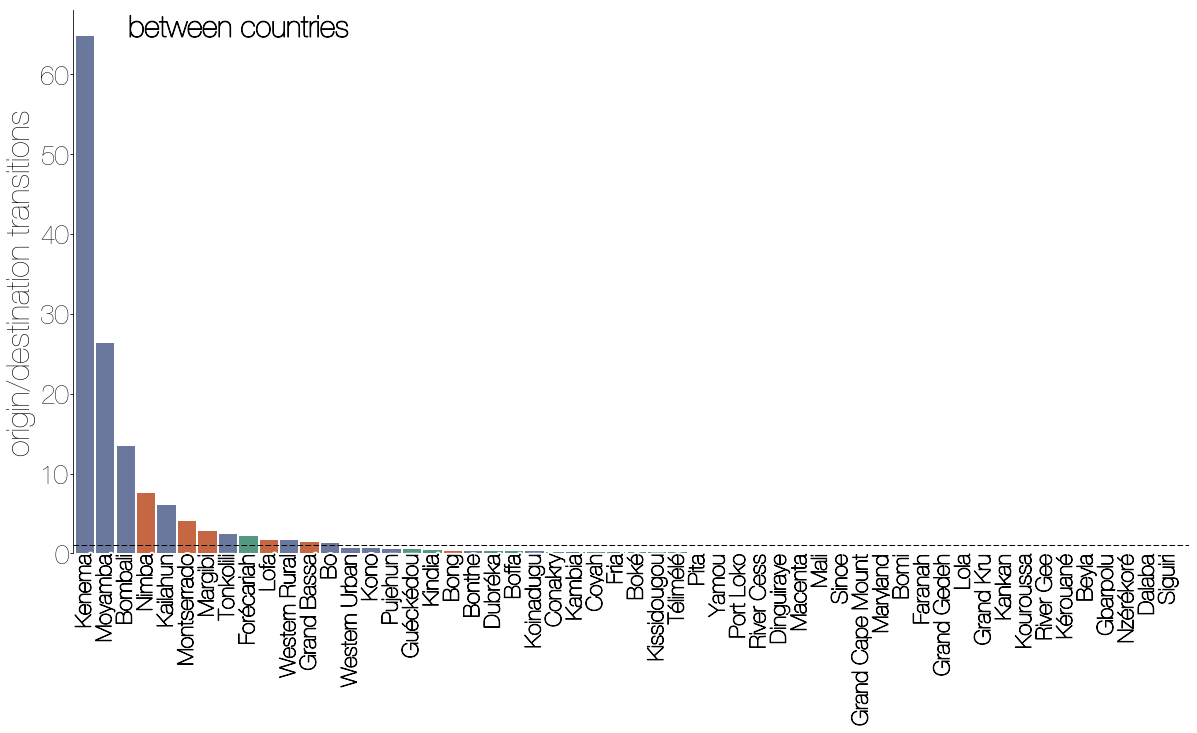

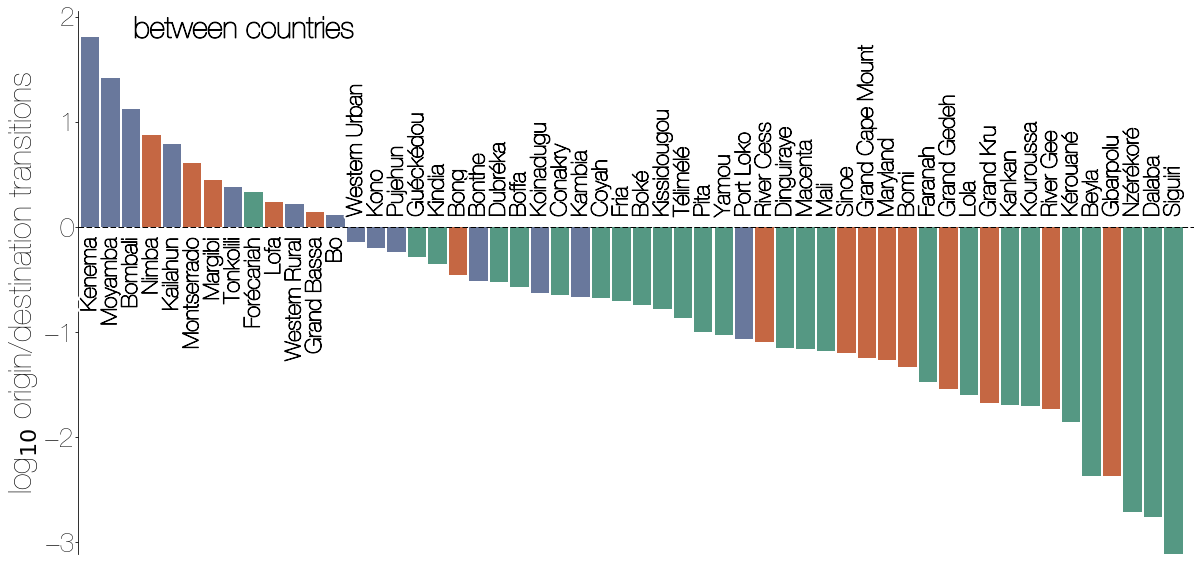

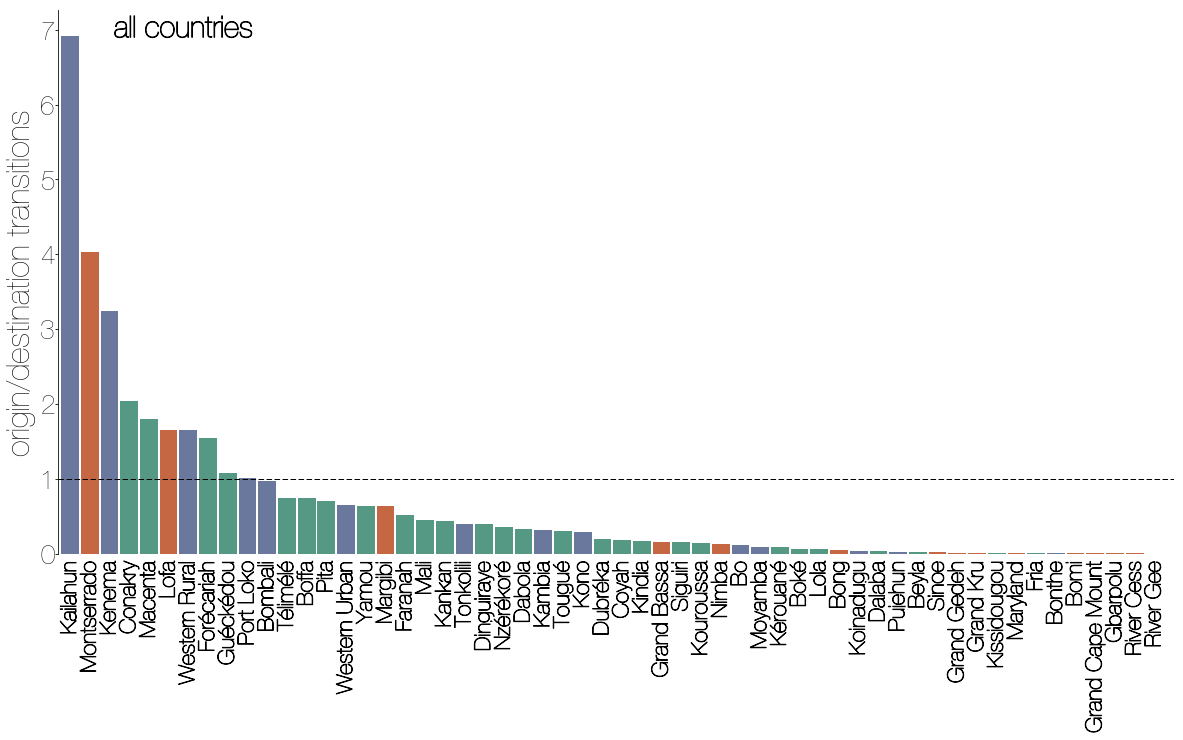

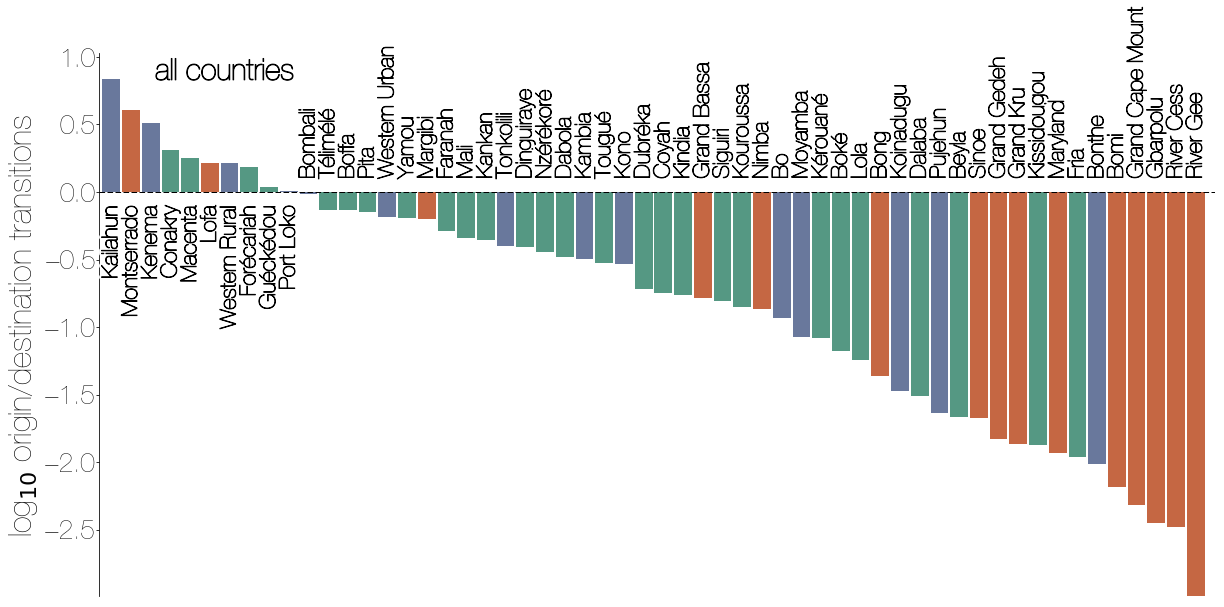

In [4]:
for category in ['within','between','all']: ## iterate over categories
    flux={}
    log_flux={}
    
    for i in xml_districts: ## count transitions to and from each location
        transitions_within=[x for x in popCentres.keys() if location_to_country[x]==location_to_country[i] and i!=x]
        transitions_between=[x for x in popCentres.keys() if location_to_country[x]!=location_to_country[i]]

        if category=='within':
            froms=sum([jump_matrix[i][x] for x in transitions_within])
            tos=sum([jump_matrix[x][i] for x in transitions_within if x!=i])

        elif category=='between':
            froms=sum([jump_matrix[i][x] for x in transitions_between])
            tos=sum([jump_matrix[x][i] for x in transitions_between if x!=i])

        elif category=='all':
            froms=sum(jump_matrix[i].values())
            tos=sum([jump_matrix[x][i] for x in jump_matrix.keys() if x!=i])

        flux[i]=froms/float(tos) ## divide sum of origin transitions by sum of destination transitions
        log_flux[i]=np.log10(froms/float(tos)) ## log the ratio

    effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1, foreground='black')]
    
    for kind in [flux,log_flux]: ## iterate over regular and logged ratios
        fig,ax = plt.subplots(figsize=(20,10),facecolor='w') ## start figure
        
        sorted_flux=sorted(xml_districts,key=lambda x:-kind[x]) ## sort locations by value
        bar_colours=[desaturate(colours[location_to_country[label]](normalized_coords[label]),0.8) for label in sorted_flux]

        adjust=0.6
        plotted=adjust
        for i in range(len(sorted_flux)): ## iterate over sorted locations
            loc=sorted_flux[i]
            val=kind[loc]
            fc=bar_colours[i]
            fc=colours[location_to_country[loc]](0.5)
            ec='none'
            lw=2

            if val!=-np.inf and np.log10(val)!=-np.inf: ## if location value is valid (not 0 in log space)
                ax.bar(i+adjust,val,facecolor=fc,edgecolor=ec,width=0.9,lw=lw,align='center') ## plot bar

                label_loc='bottom'
                yloc=0.1
                if val>0.0:
                    label_loc='top'
                    yloc=-1*yloc

                ax.text(i+adjust,yloc,'%s'%(map_to_actual[loc]),rotation=90,size=22,va=label_loc,ha='center',
                        color='k',path_effects=effects) ## add location name to bar

                plotted+=1

        ax.set_xlim(0,plotted)
        ax.tick_params(axis='x',size=0)
        ax.set_xticklabels([])
        ax.tick_params(axis='y',labelsize=26,direction='out',pad=0)
        ax.yaxis.tick_left()

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax.text(0.05,0.95,'%s countries'%(category),size=30,transform=ax.transAxes,path_effects=effects) ## label plot

        if min(kind.values())<0.0:
            ax.set_ylabel('log$_{10}$ origin/destination transitions',size=32)
            ax.axhline(0.0,color='k',lw=1,ls='--')
#             plt.savefig(local_output+'EBOV_%s_country_logTransitions.png'%(category),dpi=300,bbox_inches='tight')
#             plt.savefig(local_output+'EBOV_%s_country_logTransitions.pdf'%(category),dpi=300,bbox_inches='tight')

        else:
            ax.set_ylabel('origin/destination transitions',size=32)
            ax.axhline(1.0,color='k',lw=1,ls='--')
#             plt.savefig(local_output+'EBOV_%s_country_transitions.png'%(category),dpi=300,bbox_inches='tight')
#             plt.savefig(local_output+'EBOV_%s_country_transitions.pdf'%(category),dpi=300,bbox_inches='tight')

        plt.show()

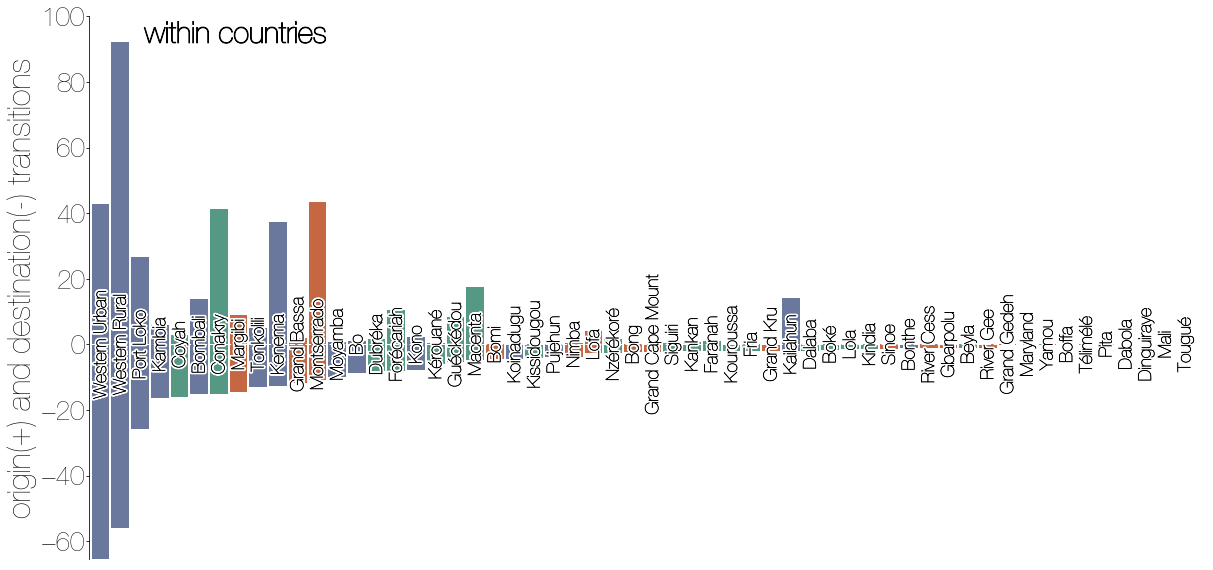

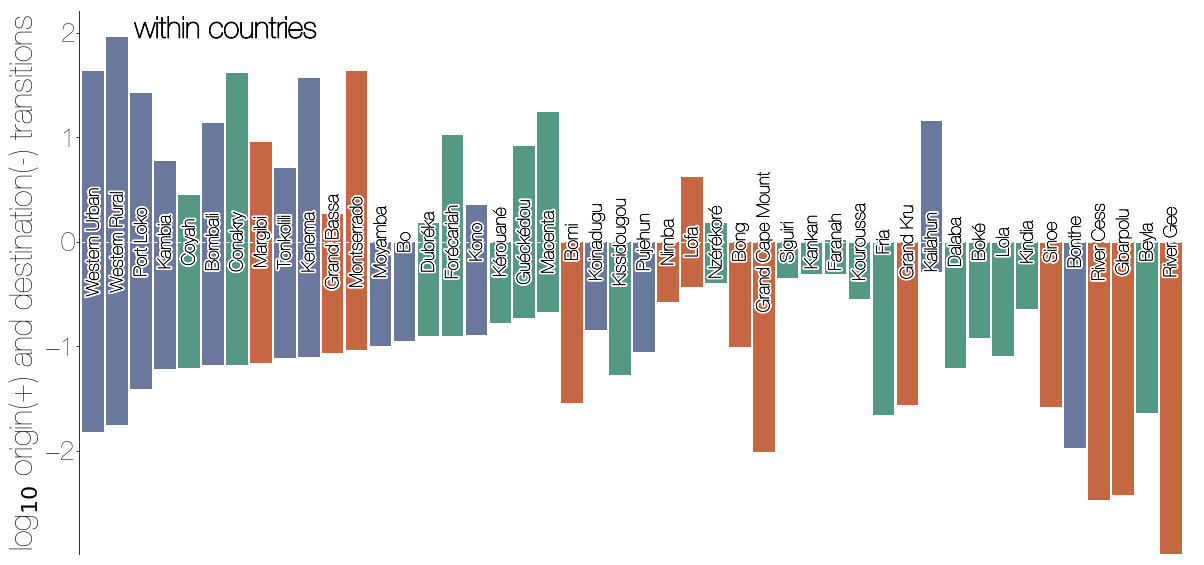

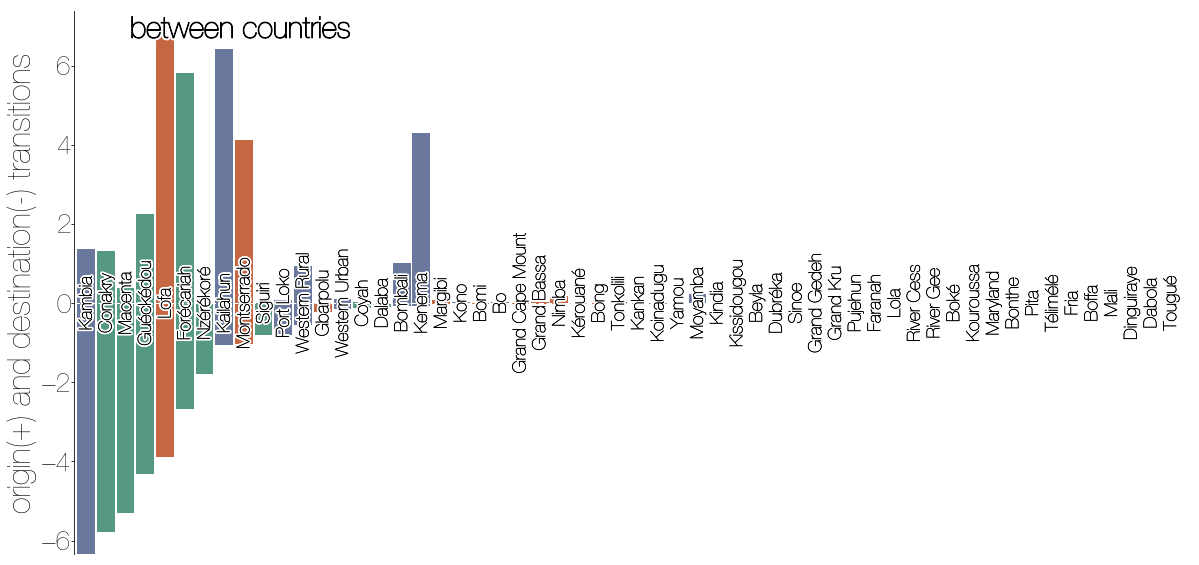

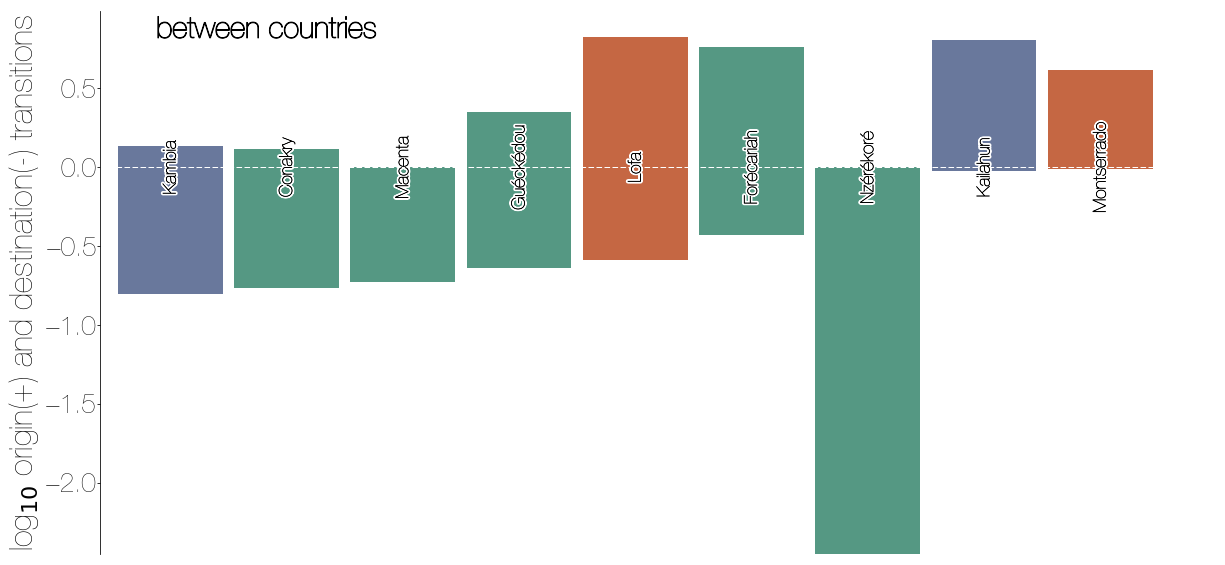

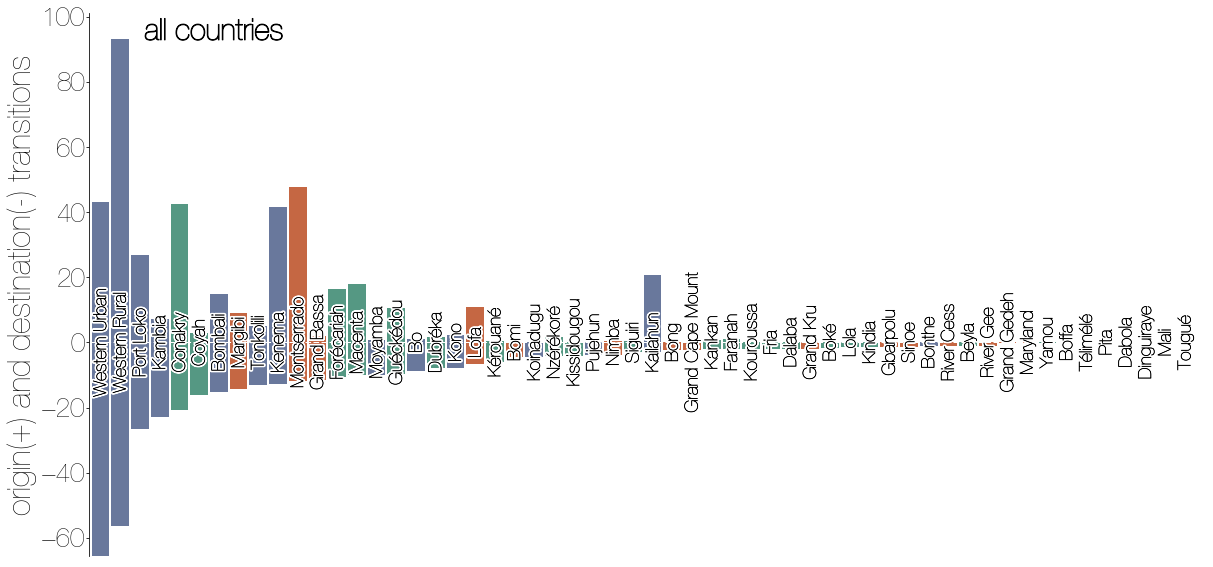

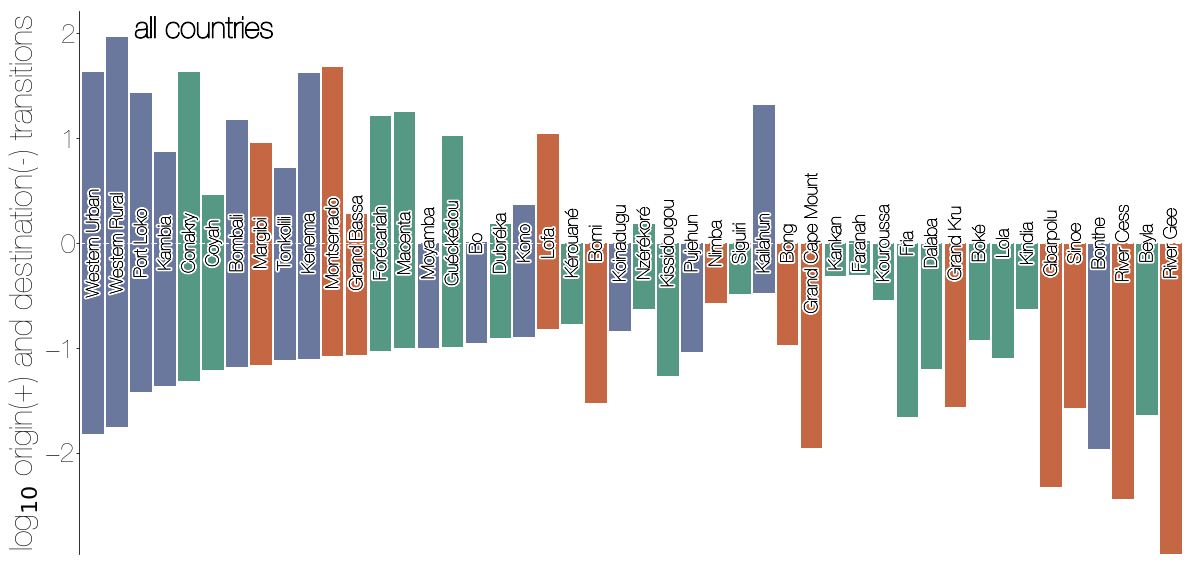

In [5]:
effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]

for category in ['within','between','all']: ## iterate over categories
    
    fluxFrom={}
    log_fluxFrom={}

    fluxTo={}
    log_fluxTo={}
    
    for i in xml_districts: ## iterate over locations, separate out jumps as within or between countries
        transitions_within=[x for x in popCentres.keys() if location_to_country[x]==location_to_country[i] and i!=x]
        transitions_between=[x for x in popCentres.keys() if location_to_country[x]!=location_to_country[i]]

        if category=='within':
            froms=sum([jump_matrix[i][x] for x in transitions_within])/float(MCMClen)
            tos=sum([jump_matrix[x][i] for x in transitions_within if x!=i])/float(MCMClen)

        elif category=='between':
            froms=sum([jump_matrix[i][x] for x in transitions_between])/float(MCMClen)
            tos=sum([jump_matrix[x][i] for x in transitions_between if x!=i])/float(MCMClen)

        elif category=='all':
            froms=sum(jump_matrix[i].values())/float(MCMClen)
            tos=sum([jump_matrix[x][i] for x in jump_matrix.keys() if x!=i])/float(MCMClen)

        fluxTo[i]=float(tos)
        log_fluxTo[i]=np.log10(float(tos))

        fluxFrom[i]=float(froms)
        log_fluxFrom[i]=np.log10(float(froms))

    for kind in [[fluxFrom,fluxTo],[log_fluxFrom,log_fluxTo]]: ## iterate over normal and log space origin-destination pairs
        fig,ax = plt.subplots(figsize=(20,10),facecolor='w') ## start figure

        origin,destination=kind
#         sorted_flux=sorted(sorted_locations,key=lambda x:-destination[x]-origin[x])
#         sorted_flux=sorted(sorted_locations,key=lambda x:-origin[x])
        sorted_flux=sorted([loc for loc in xml_districts if destination[loc]>0],key=lambda x:-destination[x])
        bar_colours=[desaturate(colours[location_to_country[label]](normalized_coords[label]),0.8) for label in sorted_flux]

        adjust=0.6
        plotted=adjust
        for i in range(len(sorted_flux)):
            loc=sorted_flux[i]
            val1=origin[loc]#/float(MCMClen)
            val2=destination[loc]#/float(MCMClen)
            #print loc,val1,val2
            fc=bar_colours[i]
            fc=colours[location_to_country[loc]](0.5)
            ec='none'
            lw=2
            ax.bar(i+adjust,val1,facecolor=fc,edgecolor=ec,width=0.9,align='center',lw=lw)
            ax.bar(i+adjust,-val2,facecolor=fc,edgecolor=ec,width=0.9,align='center',lw=lw)

            yloc=0.0
            ax.text(i+adjust,yloc,'%s'%(map_to_actual[loc]),rotation=90,size=18,va='center',ha='center',
                    color='k',path_effects=effects)

            plotted+=1

        ax.set_xlim(0,plotted)
        ax.tick_params(axis='x',size=0)
        ax.set_xticklabels([])
        ax.tick_params(axis='y',labelsize=26,direction='out',pad=0)
        ax.yaxis.tick_left()

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax.text(0.05,0.95,'%s countries'%(category),size=30,transform=ax.transAxes,path_effects=[path_effects.Stroke(linewidth=5, foreground='white'),path_effects.Stroke(linewidth=1, foreground='black')])

        ax.axhline(0.0,color='w',lw=1,ls='--')
        
        if min(origin.values())<0.0:
            ax.set_ylabel('log$_{10}$ origin(+) and destination(-) transitions',size=32)
            #plt.savefig(local_output+'EBOV_%s_country_logTransitionRange.png'%(category),dpi=300,bbox_inches='tight')
            #plt.savefig(local_output+'EBOV_%s_country_logTransitionRange.pdf'%(category),dpi=300,bbox_inches='tight')

        else:
            ax.set_ylabel('origin(+) and destination(-) transitions',size=32)
            
#             plt.savefig(local_output+'EBOV_%s_country_transitionRange.png'%(category),dpi=300,bbox_inches='tight')
#             plt.savefig(local_output+'EBOV_%s_country_transitionRange.pdf'%(category),dpi=300,bbox_inches='tight')

        plt.show()


SLE export: 14.52 14 11-18
SLE import: 9.14 9 6-12

LBR export: 11.16 11 7-15
LBR import: 5.29 5 4-7

GIN export: 9.78 10 7-13
GIN import: 21.03 21 16-25


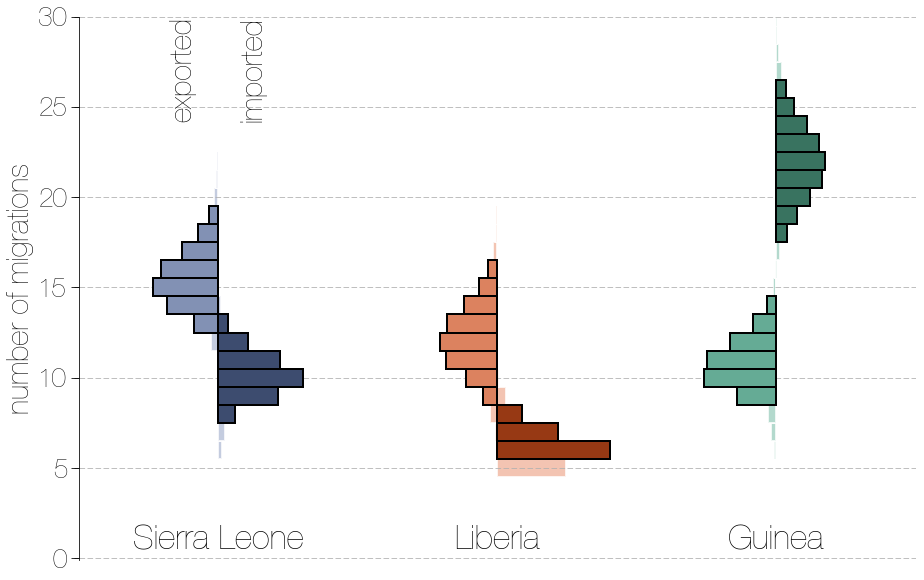

In [6]:
fig,ax = plt.subplots(figsize=(15,10),facecolor='w')
translate={'SLE':'Sierra Leone','LBR':'Liberia','GIN':'Guinea'}

for country in required_countries: ## iterate over countries
   
    tos=country_jump_to[country].values() ## fetch all introduction counts
    froms=country_jump_from[country].values() ## fetch all export counts

    mu_from=np.mean(froms)
    med_from=np.median(froms)
    hpdLo_from,hpdHi_from=hpd(froms,0.95)

    mu_to=np.mean(tos)
    med_to=np.median(tos)
    hpdLo_to,hpdHi_to=hpd(tos,0.95)

    print '\n%s export: %.2f %d %d-%d'%(country,mu_from,med_from,hpdLo_from,hpdHi_from)
    print '%s import: %.2f %d %d-%d'%(country,mu_to,med_to,hpdLo_to,hpdHi_to)

    adjust_x=required_countries.index(country)+1

    if adjust_x==1:
        ax.text(adjust_x-0.125,30,'exported',size=30,rotation=90,va='top',ha='center')
        ax.text(adjust_x+0.125,30,'imported',size=30,rotation=90,va='top',ha='center')

    ax.text(adjust_x,1,translate[country],size=34,va='center',ha='center') ## add country labels

    for x in sorted(unique(froms)): ## iterate over export numbers
        if hpdLo_from<x<=hpdHi_from: ## one colour for within HPDs
            fc=colours[country](0.4)
            ec='k'
            al=1
            z=10
        else: ## another for outside HPDs
            fc=colours[country](0.2)
            ec='w'
            al=0.8
            z=1

        ax.barh(x+1,-froms.count(x)/float(len(froms)),left=adjust_x,facecolor=fc,edgecolor=ec,
                lw=2,height=1.0,align='center',alpha=al,zorder=z) ## horizontal bars indicating posterior probability for any given count

    for x in sorted(unique(tos)): ## mirror bar for introductions
        if hpdLo_to<x<=hpdHi_to:
            fc=colours[country](0.7)
            ec='k'
            al=1
            z=10
        else:
            fc=colours[country](0.2)
            ec='w'
            al=0.8
            z=1
            
        ax.barh(x+1,tos.count(x)/float(len(tos)),left=adjust_x,facecolor=fc,ec=ec,
                    lw=2,height=1.0,align='center',alpha=al,zorder=z)

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))

ax.tick_params(axis='y',labelsize=26,size=8,direction='out')
ax.tick_params(axis='y',which='minor',labelsize=0,size=5,direction='out')
ax.tick_params(axis='x',size=0)
ax.set_xticklabels([])

ax.set_ylabel('number of migrations',size=30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlim(0.5,3.5)
ax.set_ylim(-0.1,30)
ax.grid(axis='y',which='minor',ls='--',zorder=0)

# plt.savefig(local_output+'EBOV_countryJumpCount_probs.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_countryJumpCount_probs.pdf',dpi=300,bbox_inches='tight')

plt.show()

SLE > LBR:   4 [   2 -   5 ]
SLE > GIN:  11 [   8 -  14 ]
LBR > SLE:   1 [   1 -   2 ]
LBR > GIN:  10 [   7 -  14 ]
GIN > SLE:   8 [   6 -  11 ]
GIN > LBR:   1 [   1 -   3 ]


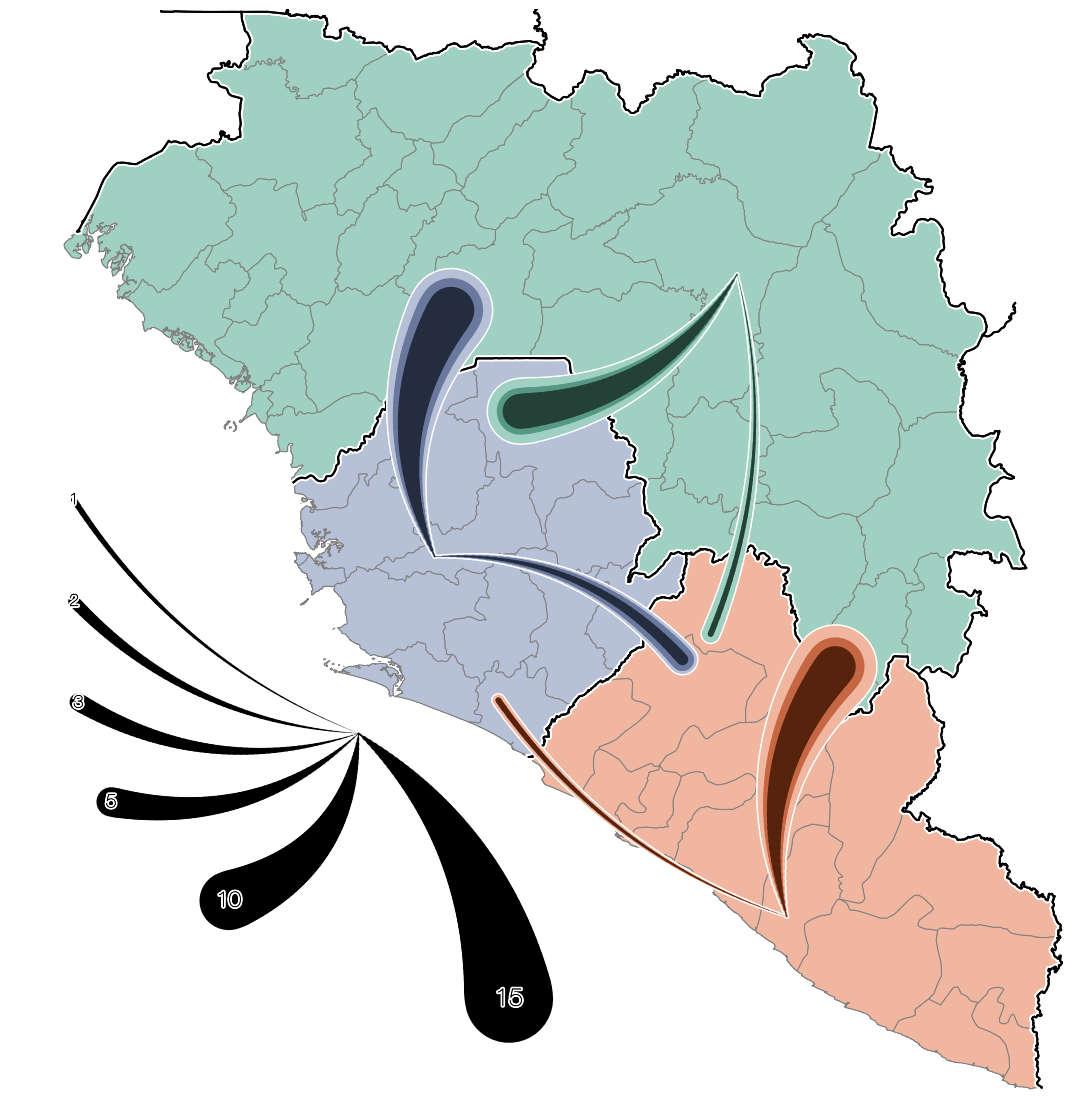

In [7]:
## start figure
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

## plot all locations
for loc in popCentres.keys():
    country=location_to_country[loc]
    if country in required_countries:
        countryColour=colours[country]
        c=countryColour(0.2)

        ## plot every part of each location (islands, etc)
        for part in location_points[loc]:
            poly=plt.Polygon(part,facecolor=c,edgecolor='grey',closed=True)
            ax.add_patch(poly)

## plot the international borders
for l,local_border in enumerate(global_border):
    ax.plot(column(local_border,0),column(local_border,1),lw=2,color='k',zorder=97,label='%d_border'%(l))
    ax.plot(column(local_border,0),column(local_border,1),lw=6,color='w',zorder=96,label='%d_border'%(l))
    
jump_directions={'SLE':{'GIN':('Tonkolili','Mamou'),'LBR':('Tonkolili','Gbarpolu')},'GIN':{'SLE':('Kouroussa','Koinadugu'),'LBR':('Kouroussa','Lofa')},'LBR':{'SLE':('RiverCess','Pujehun'),'GIN':('RiverCess','Yamou')}} ## define location population centroids that will represent country-to-country jump origins and destinations

for countryA in jump_directions.keys(): ## iterate over origin countries
    for countryB in jump_directions.keys(): ## iterate over destination countries
        if countryA!=countryB:
            locA,locB=jump_directions[countryA][countryB] ## fetch locations

            fc=colours[countryA] ## get colour
            
            pointA=popCentres[locA] ## get population centroids
            beginX,beginY=pointA

            pointB=popCentres[locB]
            endX,endY=pointB

            ## calculate distance between locations
            distance=math.sqrt(math.pow(beginX-endX,2)+math.pow(beginY-endY,2))
            
            #############
            ## this controls the distance at which the Bezier line control point will be placed
            #############
            adjust_d=-1+0.1+1/float(distance)**0.15+0.5
            ## find the coordinates of a point n that is at a distance adjust_d, perpendicular to the mid-point between points A and B
            n=Bezier_control(pointA,pointB,adjust_d)

            bezier_start=0.0
            bezier_end=1.0

            ## get Bezier line points
            bezier_line=Bezier([pointA,n,pointB],bezier_start,bezier_end,num=40)

            posteriorCounts=[len(x) for x in country_jump_matrix[countryA][countryB].values()] ## get posterior counts of jumps

            med=np.median(posteriorCounts)
            hpdLo,hpdHi=hpd(posteriorCounts,0.95)
            print '%s > %s: %3d [ %3d - %3d ]'%(countryA,countryB,med,hpdLo,hpdHi)
            
            ## iterate through Bezier line segments with fading alpha and reducing width
            for q in range(len(bezier_line)-1):
                x1,y1=bezier_line[q]
                x2,y2=bezier_line[q+1]

                ## fraction along length of Bezier line
                segL=(q+1)/float(len(bezier_line))

                ## plot jumps
                ax.plot([x1,x2],[y1,y2],lw=6*hpdLo*segL,alpha=1,color=fc(1.0),zorder=100,solid_capstyle='round')
                ax.plot([x1,x2],[y1,y2],lw=6*med*segL,alpha=1,color=fc(0.5),zorder=99,solid_capstyle='round')
                ax.plot([x1,x2],[y1,y2],lw=6*hpdHi*segL,alpha=1,color=fc(0.2),zorder=98,solid_capstyle='round')
                ax.plot([x1,x2],[y1,y2],lw=3+6*hpdHi*segL,alpha=1,color='w',zorder=97,solid_capstyle='round')

import matplotlib.patheffects as path_effects

effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]

display=[1,2,3,5,10,15] ## missile sizes for legend
positions=np.linspace(5,8.5,len(display))[::-1] ## positions for missile legend
for i,x in enumerate(positions): ## iterate over missile legend numbers, plot
    beginX=-12.8
    beginY=7.1

    endX=-15+len(display)*4e-10*sum(positions[:i])**5.9
    endY=x+(sum(positions)-sum(positions[:i]))*0.01

    ax.text(endX,endY,'%d'%(display[i]),size=16+display[i]*0.6,va='center',ha='center',path_effects=effects,zorder=200)

    distance=math.sqrt(math.pow(beginX-endX,2)+math.pow(beginY-endY,2))
    adjust_d=-1+0.1+1/float(distance)**0.15+0.5
    n=Bezier_control((beginX,beginY),(endX,endY),adjust_d)

    bezier_start=0.0
    bezier_end=1.0

    bezier_line=Bezier([(beginX,beginY),n,(endX,endY)],bezier_start,bezier_end,num=50)

    for q in range(len(bezier_line)-1):
        x1,y1=bezier_line[q]
        x2,y2=bezier_line[q+1]
        segL=(q+1)/float(len(bezier_line))

        ax.plot([x1,x2],[y1,y2],lw=6*display[i]*segL,alpha=1,color='k',zorder=100,solid_capstyle='round')

## make map pretty
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(ylimits)
ax.set_xlim(xlimits)

# plt.savefig(local_output+'EBOV_countryJump_summary.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_countryJump_summary.pdf',dpi=300,bbox_inches='tight')

plt.show()

             Macenta >          Montserrado:   1 [   1 -   1 ]
           Gueckedou >          Montserrado:   1 [   1 -   1 ]
          Forecariah >         WesternRural:   1 [   1 -   1 ]
                  Bo >              Conakry:   1 [   1 -   1 ]
                Lofa >            Nzerekore:   1 [   1 -   1 ]
                Lofa >              Conakry:   1 [   1 -   1 ]
              Kambia >                Coyah:   1 [   1 -   1 ]
              Kambia >              Siguiri:   1 [   1 -   1 ]
              Kambia >              Conakry:   1 [   1 -   2 ]
              Kenema >              Macenta:   1 [   1 -   1 ]
              Kenema >           Forecariah:   1 [   1 -   1 ]
              Kenema >                Coyah:   1 [   1 -   1 ]
              Kenema >          Montserrado:   1 [   1 -   1 ]
              Kenema >               Dalaba:   1 [   1 -   1 ]
              Kenema >              Conakry:   4 [   2 -   5 ]
            PortLoko >              Conakry:   1 [   1 

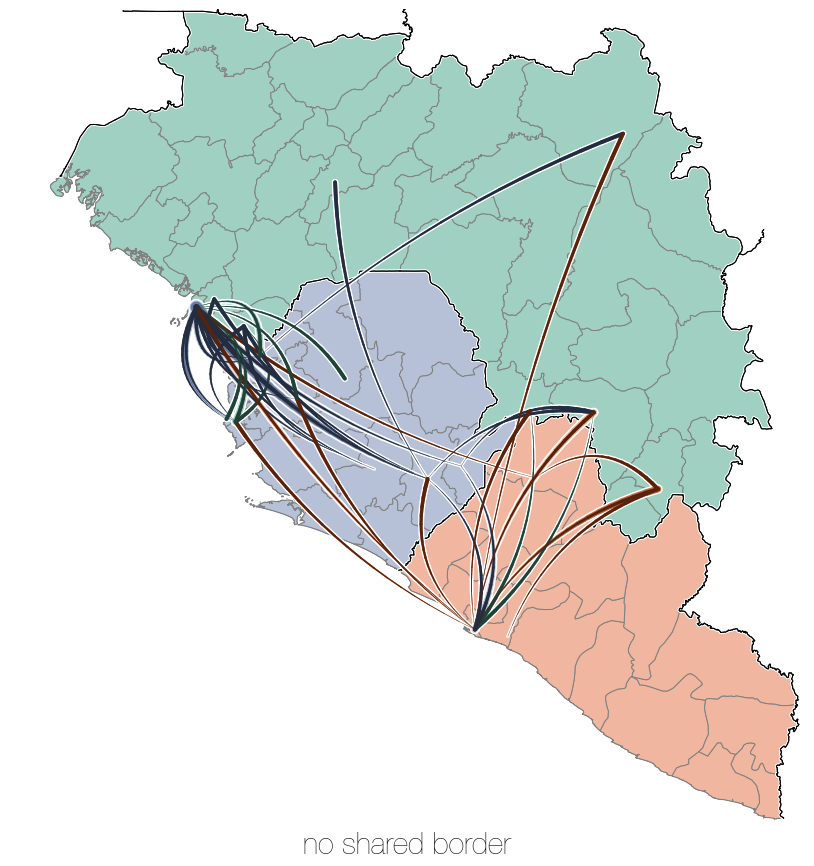

             Macenta >                 Lofa:   1 [   1 -   2 ]
           Gueckedou >                 Lofa:   1 [   1 -   2 ]
           Gueckedou >             Kailahun:   1 [   1 -   1 ]
          Forecariah >               Kambia:   6 [   2 -   8 ]
          Forecariah >              Bombali:   1 [   1 -   1 ]
                Lofa >              Macenta:   5 [   1 -   8 ]
                Lofa >            Gueckedou:   2 [   1 -   4 ]
                Lofa >             Kailahun:   1 [   1 -   1 ]
              Kambia >           Forecariah:   1 [   1 -   3 ]
            Kailahun >             Gbarpolu:   1 [   1 -   1 ]
            Kailahun >            Gueckedou:   2 [   1 -   4 ]
            Kailahun >                 Lofa:   3 [   1 -   4 ]
               Nimba >            Nzerekore:   1 [   1 -   1 ]
             Bombali >           Forecariah:   1 [   1 -   2 ]


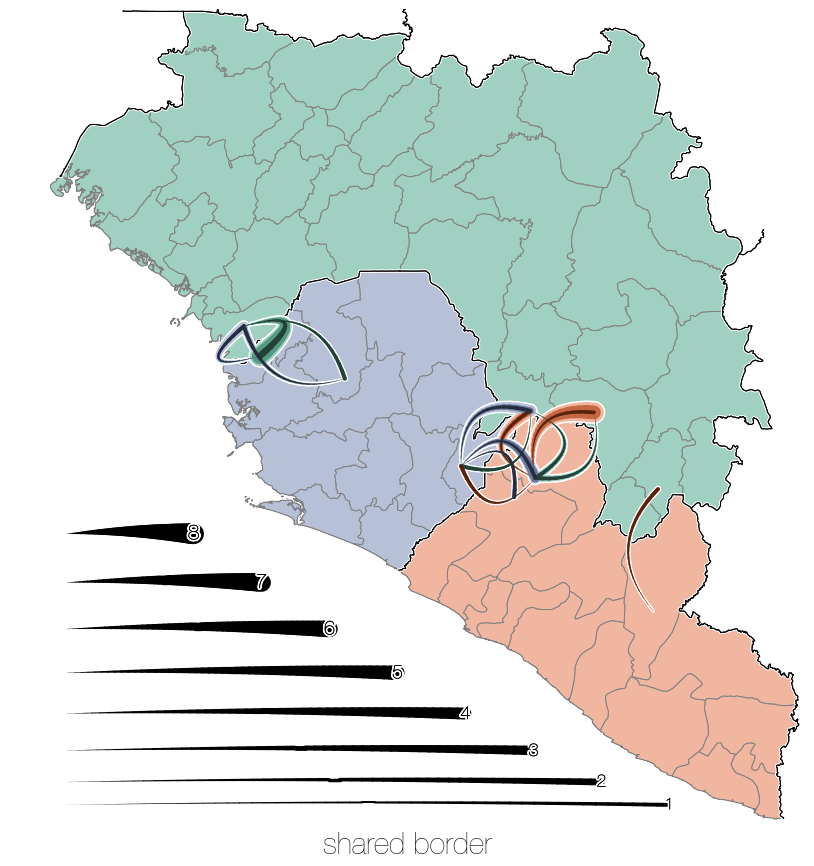

In [8]:
## start figure
# fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

# fig = plt.figure(figsize=(20, 20))
#gs = gridspec.GridSpec(1, 2,hspace=0.0,wspace=0.0)

cutoff=decimalDate('2014-09-01')


for b in range(2):
    a=0
#     for b in range(2):

#     ax=plt.subplot(gs[a,b])
    fig,ax = plt.subplots(figsize=(15,15),facecolor='w')
    
    def timeCondition(time):
        return True
    
    
    if b==0:
        def locCondition(locA,locB):
            ## don't share border
            if shared_border[locA][locB]==False:
                return True
            else:
                return False

        if a==0:
            ax.set_xlabel('no shared border',size=30)
    elif b==1:
        def locCondition(locA,locB):
            ## don't share border
            if shared_border[locA][locB]==True:
                return True
            else:
                return False
        if a==0:
            ax.set_xlabel('shared border',size=30)

#     if a==0:
# #             def timeCondition(time):
# #                 if time<cutoff:
# #                     return True
# #                 else:
# #                     return False

#         if b==1:
#             ax.set_ylabel('before 2014 September',size=30)
#     elif a==1:
# #         def timeCondition(time):
# #             if time>cutoff:
# #                 return True
# #             else:
# #                 return False
#         if b==1:
#             ax.set_ylabel('after 2014 September',size=30)


    ## plot all locations
    for loc in popCentres.keys():
        country=location_to_country[loc]
        if country in required_countries:
            countryColour=colours[country]
            c=countryColour(0.2)

            # plot every part of each location (islands, etc)
            for part in location_points[loc]:
                poly=plt.Polygon(part,facecolor=c,edgecolor='grey',closed=True)
                ax.add_patch(poly)

    # ## plot the international borders
    for l,local_border in enumerate(global_border):
        ax.plot(column(local_border,0),column(local_border,1),lw=1,color='k',zorder=97,label='%d_border'%(l))
        ax.plot(column(local_border,0),column(local_border,1),lw=3,color='w',zorder=96,label='%d_border'%(l))


    for locA in popCentres.keys():
        for locB in popCentres.keys():
            if locA!=locB and location_to_country[locA]!=location_to_country[locB] and locCondition(locA,locB)==True: ## locations are in different countries and satisfy the location condition defined earlier
#                 if locA!=locB and location_to_country[locA]==location_to_country[locB] and locCondition(locA,locB)==True:
    #         if locA!=locB:

    #             posteriorCounts=[len(x) for x in location_jump_matrix[locA][locB].values()]
                posteriorCounts=[len([t for t in x if timeCondition(t)==True]) for x in location_jump_matrix[locA][locB].values()]

    #             if len(posteriorCounts)/float(MCMClen)>0.1:
                if len(posteriorCounts)>1000: ## only interested in decently supported jumps
                    fc=colours[location_to_country[locA]]

                    pointA=popCentres[locA]
                    beginX,beginY=pointA

                    pointB=popCentres[locB]
                    endX,endY=pointB

                    ## calculate distance between locations
                    distance=math.sqrt(math.pow(beginX-endX,2)+math.pow(beginY-endY,2))

                    adjust_d=-1+0.1+1/float(distance)**0.15+0.5
                    ## find the coordinates of a point n that is at a distance adjust_d, perpendicular to the mid-point between points A and B
                    n=Bezier_control(pointA,pointB,adjust_d)

                    ## Bezier line starts at origin and ends at destination
                    bezier_start=0.0
                    bezier_end=1.0

                    ## get Bezier line points
                    bezier_line=Bezier([pointA,n,pointB],bezier_start,bezier_end,num=20)

                    med=np.median(posteriorCounts)
                    hpdLo,hpdHi=hpd(posteriorCounts,0.95)
                    if hpdHi>0 and location_to_country[locA]!=location_to_country[locB]:
                        print '%20s > %20s: %3d [ %3d - %3d ]'%(locA,locB,med,hpdLo,hpdHi)

                    ## iterate through Bezier line segments with fading alpha and reducing width
                    for q in range(len(bezier_line)-1):
                        x1,y1=bezier_line[q]
                        x2,y2=bezier_line[q+1]

                        ## fraction along length of Bezier line
                        segL=(q+1)/float(len(bezier_line))

                        scalar=4
                        ## plot actual jump
                        ax.plot([x1,x2],[y1,y2],lw=scalar*(hpdLo**0.8)*segL,alpha=1,color=fc(1.0),zorder=100,
                                solid_capstyle='round')
                        ax.plot([x1,x2],[y1,y2],lw=scalar*(med**0.8)*segL,alpha=1,color=fc(0.5),zorder=99,
                                solid_capstyle='round')
                        ax.plot([x1,x2],[y1,y2],lw=scalar*(hpdHi**0.8)*segL,alpha=1,color=fc(0.2),zorder=98,
                                solid_capstyle='round')
                        if hpdHi>0:
                            ax.plot([x1,x2],[y1,y2],lw=3+scalar*(hpdHi**0.8)*segL,alpha=1,color='w',zorder=97,
                                solid_capstyle='round')

    if a==0 and b==1:
        import matplotlib.patheffects as path_effects

        effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]

        display=[1,2,3,4,5,6,7,8]
        positions=np.linspace(5,8.5,len(display))
        for i,x in enumerate(positions):
            beginX=-14.9
            beginY=4.5+i*(np.log(sum(positions[:i+1]))*0.1)

            endX=-15+(len(display)-i+1)*0.7
            endY=beginY

            ax.text(endX,endY,'%d'%(display[i]),size=16+display[i]*0.6,va='center',ha='center',path_effects=effects,zorder=200)

            ## calculate distance between locations
            distance=math.sqrt(math.pow(beginX-endX,2)+math.pow(beginY-endY,2))

            adjust_d=0.05
            ## find the coordinates of a point n that is at a distance adjust_d, perpendicular to the mid-point between points A and B
            n=Bezier_control((beginX,beginY),(endX,endY),adjust_d)

            bezier_start=0.0
            bezier_end=1.0

            ## get Bezier line points
            bezier_line=Bezier([(beginX,beginY),n,(endX,endY)],bezier_start,bezier_end,num=50)

            ## iterate through Bezier line segments with fading alpha and reducing width
            for q in range(len(bezier_line)-1):
                x1,y1=bezier_line[q]
                x2,y2=bezier_line[q+1]

                ## fraction along length of Bezier line
                segL=(q+1)/float(len(bezier_line))
                scalar=4
                ## plot actual jump
                ax.plot([x1,x2],[y1,y2],lw=scalar*(display[i]**0.8)*segL,alpha=1,color='k',zorder=100,
                        solid_capstyle='round')

    ## make map pretty
    ax.set_aspect('equal')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylim(ylimits)
    ax.set_xlim(xlimits)
    
#     if b==0:
#         plt.savefig(local_output+'Fig4_international_distant.png',dpi=300,bbox_inches='tight')
#         plt.savefig(local_output+'Fig4_international_distant.pdf',dpi=300,bbox_inches='tight')
#     elif b==1:
#         plt.savefig(local_output+'Fig4_international_shared.png',dpi=300,bbox_inches='tight')
#         plt.savefig(local_output+'Fig4_international_shared.pdf',dpi=300,bbox_inches='tight')
    plt.show()

In [9]:
border_jump_path=path_to_dropbox+'Sequences/Jun2016_1610_genomes/GLM/homogeneous/56_locations/Primary/jumps/jumpsIntNatBorders.txt'


for line in open(border_jump_path,'r'):
    l=line.strip('\n').split('\t')
    if l[0]=='state':
        header=l[1:]
        border_jumps={x:[] for x in header}
    elif int(l[0])>0:
        for i,x in enumerate(l):
            if i>0:
                border_jumps[header[i-1]].append(float(x))

['intNoBorder', 'natNoBorder', 'intSharedBorder', 'natSharedBorder']


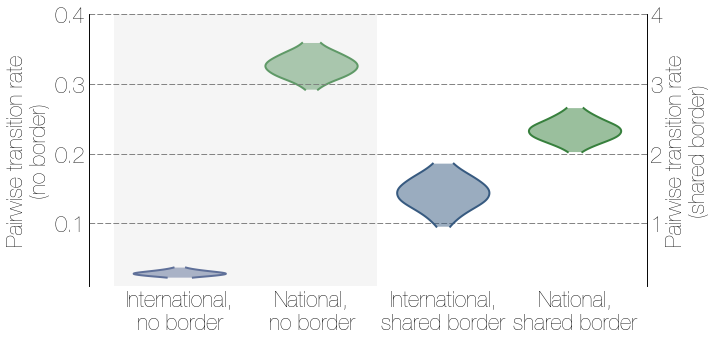

In [10]:
fig,ax1 = plt.subplots(figsize=(10,5),facecolor='w')

ax2=ax1.twinx()

kinds=sorted(border_jumps.keys(),key = lambda x:('Shared' in x,'nat' in x))
print kinds
translate={'natNoBorder':'National,\nno border', 
           'intNoBorder':'International,\nno border', 
           'natSharedBorder':'National,\nshared border', 
           'intSharedBorder':'International,\nshared border'}

kind_colours={'natNoBorder':'#5F9967', 
              'intNoBorder':'#5F7099', 
              'natSharedBorder':'#37803D', 
              'intSharedBorder':'#375A80'}

for k,kind in enumerate(kinds):
    hpdHi,hpdLo=hpd(border_jumps[kind],0.95)
    x_grid=np.linspace(hpdLo,hpdHi,101)
    
    kde=gaussian_kde(border_jumps[kind],bw_method=0.3)
    y_grid=kde.evaluate(x_grid)
    y_grid=y_grid/y_grid.max()*0.35
    
    if 'No' in kind:
        ax=ax1
        ax.set_ylim(0.01,0.4)
        ax.set_ylabel('Pairwise transition rate\n(no border)')
    else:
        ax=ax2
        ax.set_ylim(0.1,4.0)
        ax.set_ylabel('Pairwise transition rate\n(shared border)')
    ax.plot([k+y for y in y_grid],x_grid,color=kind_colours[kind],lw=2,zorder=100)
    ax.plot([k-y for y in y_grid],x_grid,color=kind_colours[kind],lw=2,zorder=100)
    
    ax.fill_betweenx(x_grid,[k-y for y in y_grid],[k+y for y in y_grid],facecolor=kind_colours[kind],edgecolor='none',alpha=0.5,zorder=100)

    ax.set_xticks(range(len(kinds)))
    ax.set_xticklabels([translate[k] for k in kinds])

    ax.grid(axis='y',ls='--',color='grey',zorder=0)

    ax.xaxis.tick_bottom()

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(size=0)

ax1.axvspan(-0.5,1.5,facecolor='grey',edgecolor='none',alpha=0.08,zorder=0)

# plt.savefig(local_output+'border_rates.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'border_rates.pdf',dpi=300,bbox_inches='tight')

plt.show()